In [ ]:
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

import joblib


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Read dataset as dataframe
df = pd.read_csv("Poem_Data.csv")
pd.set_option('display.max_colwidth', None) # Set this to view the full content of cells
pd.set_option('display.max_columns', None) # set this to enable the view of all the columns in output window

In [ ]:
# Cleaning Poem
def cleaner(Poem):
    soup = BeautifulSoup(Poem, 'lxml') # To eliminate HTML entities like '&amp', '&quot', and '&gt', the lxml library should be installed with the command 'pip install lxml' as it serves as the HTML parser.
    souped = soup.get_text()
    re1 = re.sub(r"(@|http://|https://|www|\\x)\S*", " ", souped) #Replacing @mentions, URLs, and other elements with blank spaces.
    re2 = re.sub("[^A-Za-z]+"," ", re1) # Replace any recurring non-alphabetic character with whitespace.

    """
    For more info on regular expressions visit -
    https://docs.python.org/3/howto/regex.html
    """

    tokens = nltk.word_tokenize(re2)
    LowerCase = [t.lower() for t in tokens]

    StopWords = set(stopwords.words('english'))
    filteredResult = list(filter(lambda l: l not in StopWords, LowerCase))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t,'v') for t in filteredResult]
    return lemmas

In [ ]:
df['cleaned_Poem'] = df.Poem.apply(cleaner)
df = df[df['cleaned_Poem'].map(len) > 0] # removing rows with cleaned poem of length 0

<ipython-input-26-5dac02a2cd37>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(Poem, 'lxml') # To eliminate HTML entities like '&amp', '&quot', and '&gt', the lxml library should be installed with the command 'pip install lxml' as it serves as the HTML parser.


In [ ]:
# Replace NaN values in X_train with an empty string
df.fillna('', inplace=True)
print("Displaying the first 5 rows of the dataframe, showcasing both the original and cleaned versions of the poem...")
print(df[['Genre','cleaned_Poem']].head())

Displaying the first 5 rows of the dataframe, showcasing both the original and cleaned versions of the poem...
   Genre  \
1  Music   
2  Music   
3  Music   
4  Music   
5  Music   

                                                                                                                                                                                   cleaned_Poem  
1                                                                   [thick, brushthey, spend, hottest, part, day, soak, hoovesin, trickle, mountain, water, ravine, hoardson, behalf, oleander]  
2                                                                                                                [storm, generous, something, easy, surrender, sit, window, step, garden, bore]  
3  [ana, mendieta, carry, around, matin, star, hold, forest, fire, one, hand, would, wake, radiate, shimmer, gleam, lucero, light, morning, would, measure, wingspan, idea, take, night, would]  
4                                       

<ipython-input-28-5a3e6f135409>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna('', inplace=True)


In [ ]:
df

,Genre,Poem,cleaned_Poem
1,Music,"In the thick brushthey spend the hottest part of the day, soaking their hoovesin the trickle of mountain water the ravine hoardson behalf of the oleander.","[thick, brushthey, spend, hottest, part, day, soak, hoovesin, trickle, mountain, water, ravine, hoardson, behalf, oleander]"
2,Music,"Storms are generous. Something so easy to surrender to, sitting by the window, and then you step out into the garden you were so bored of,","[storm, generous, something, easy, surrender, sit, window, step, garden, bore]"
3,Music,"—After Ana Mendieta Did you carry around the matin star? Did you hold forest-fire in one hand? Would you wake to radiate, shimmer, gleam lucero-light? Through the morning would you measure the wingspan of an idea taking off— & by night would","[ana, mendieta, carry, around, matin, star, hold, forest, fire, one, hand, would, wake, radiate, shimmer, gleam, lucero, light, morning, would, measure, wingspan, idea, take, night, would]"
4,Music,"for Aja Sherrard at 20The portent may itself be memory. —Wallace StevensHow hard to carry scores of adults on your back,not look at them as carrions of need, the distressof what loyalty requires. This pain is","[aja, sherrard, portent, may, memory, wallace, stevenshow, hard, carry, score, adults, back, look, carrions, need, distressof, loyalty, require, pain]"
5,Music,"for Bob Marley, Bavaria, November 1980 Here is the brilliant morning on a fishing boat, this is the dream a dying man has in midwinter, the world covered in light and shadow—he dreams of St. Ann’s","[bob, marley, bavaria, november, brilliant, morning, fish, boat, dream, die, man, midwinter, world, cover, light, shadow, dream, st, ann]"
...,...,...,...
836,Environment,"Why make so much of fragmentary blue In here and there a bird, or butterfly, Or flower, or wearing-stone, or open eye, When heaven presents in sheets the solid hue?Since earth is earth, perhaps, not heaven (as yet)— Though some savants make earth include the sky; And blue so far above us comes so high, It","[make, much, fragmentary, blue, bird, butterfly, flower, wear, stone, open, eye, heaven, present, sheet, solid, hue, since, earth, earth, perhaps, heaven, yet, though, savants, make, earth, include, sky, blue, far, us, come, high]"
837,Environment,"Woman, I wish I didn't know your name. What could you be? Silence in my house& the front yard where the dogwoodwouldn't make up its mind about flowers.Aren't you Nature? A stem cringing, half- shadowed beneath a torque of rain.I too am leaving. I too am","[woman, wish, know, name, could, silence, house, front, yard, dogwoodwouldn, make, mind, flower, nature, stem, cringe, half, shadow, beneath, torque, rain, leave]"
838,Environment,"Yonder to the kiosk, beside the creek, Paddle the swift caque. Thou brawny oarsman with the sunburnt cheek, Quick! for it soothes my heart to hear the Bulbul speak.Ferry me quickly to the Asian shores, Swift bending to your oars. Beneath","[yonder, kiosk, beside, creek, paddle, swift, caque, thou, brawny, oarsman, sunburnt, cheek, quick, soothe, heart, hear, bulbul, speak, ferry, quickly, asian, shore, swift, bend, oars, beneath]"
839,Environment,"You come to fetch me from my work to-night When supper's on the table, and we'll see If I can leave off burying the white Soft petals fallen from the apple tree. (Soft petals, yes, but not so barren quite, Mingled with these, smooth bean and wrinkled pea;) And go along with you ere you lose","[come, fetch, work, night, supper, table, see, leave, bury, white, soft, petals, fall, apple, tree, soft, petals, yes, barren, quite, mingle, smooth, bean, wrinkle, pea, go, along, ere, lose]"


In [ ]:
# Saving cleaned Poem to csv
df.to_csv('cleaned_data.csv', index=False)
df['cleaned_Poem'] = [" ".join(row) for row in df['cleaned_Poem'].values] # joining tokens to create strings. TfidfVectorizer does not accept tokens as input
data = df['cleaned_Poem']
Y = df['Genre'] # target column
tfidf = TfidfVectorizer(min_df=.00015, ngram_range=(1,3)) # min_df=.00015A implies that each ngram (unigram, bigram, & trigram) must appear in a minimum of 30 documents in order to be considered as a token. This represents a smart approach to feature engineering.
tfidf.fit(data) # learn the entire data vocabulary
data_tfidf = tfidf.transform(data) # generating tfidf values
pd.DataFrame(pd.Series(tfidf.get_feature_names_out())).to_csv('vocabulary.csv', header=False, index=False)
print("Shape of tfidf matrix: ", data_tfidf.shape)

<ipython-input-30-765dbaacddc6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_Poem'] = [" ".join(row) for row in df['cleaned_Poem'].values] # joining tokens to create strings. TfidfVectorizer does not accept tokens as input


Shape of tfidf matrix:  (837, 44845)


In [ ]:
#Implementing Logistics Regression

# Split the data into features (Genre) and labels (Poem)
X = df['Poem'] # Features
y = df['Genre']  # Labels

In [ ]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Define a TF-IDF Vectorizer and Logistic Regression classifier
tfidf = TfidfVectorizer(max_features=1000)
log_reg = LogisticRegression(max_iter=1000)


# Create a pipeline
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('logistic_regression', log_reg)
])


In [ ]:
# Fit the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('naive_bayes', LogisticRegression(max_iter=1000))])

In [ ]:

# Make Prediction on the test set
predictions = pipeline.predict(X_test)

In [ ]:
# Model Evaluation
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4524


A accuracy score of 0.4524, sometimes denoted as 45.24%, indicates that approximately 45.24% of the model's predictions were accurate.

In [ ]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       precision    recall  f1-score   support

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4524


A accuracy score of 0.4524, sometimes denoted as 45.24%, indicates that approximately 45.24% of the model's predictions were accurate.

In [ ]:
# Calculate precision, recall, F1-score
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.4468
Recall: 0.4524
F1-score: 0.4432


* The metrics precision, recall, and F1-score were employed to assess the effectiveness of a classification model.

* Precision (0.4468): This indicator quantifies the level of correctness in the positive predictions generated by the model. Approximately 44.68% of the events that were predicted as positive were really true positives in this scenario. This metric denotes the number of chosen things that are pertinent.

* Recall (0.4524): Recall, or sensitivity, quantifies the model's capacity to correctly detect all the true positive instances. The model accurately detected around 45.24% of the total true positives. It represents the accuracy of properly predicting the actual positive cases.

* F1-score (0.4432): The F1-score represents the harmonic mean of precision and recall. It offers a unified score that takes into account both precision and recall. A higher F1-score signifies superior overall performance in relation to both false positives and false negatives. The F1-score in this instance is approximately 44.32%.

* In all, these measures indicate that the model's performance is reasonable, with comparable precision and recall values, although there is potential for enhancement. Enhancing either accuracy or recall while minimizing the impact on the other can improve the model's ability to accurately identify and classify occurrences.











In [ ]:
# Get unique labels from y_test
labels = np.unique(y_test)

In [ ]:
# Calculate the confusion matrix (cm)
cm = confusion_matrix(y_test, predictions, labels= labels)
print(cm)

[[ 9  9 11 11]
 [ 4 28 17 20]
 [ 6 10 42 11]
 [ 3 19 17 35]]


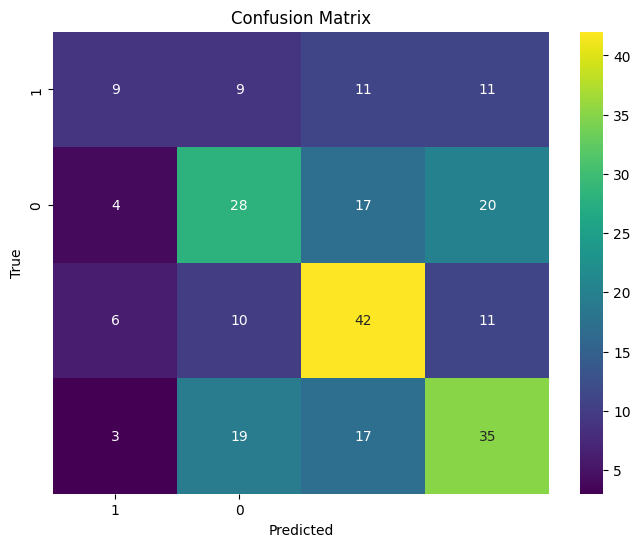

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='d', xticklabels= [1,0], yticklabels=[1,0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**SUMMARY OF THE  SENTIMENT ANALYSIS MODEL FINDINGS AND THEIR IMPLICATIONS BASED ON THE WORD FREQUENCY WORD CLOUDS AND THE PERFORMANCE.**

Considering the frequency of words in word clouds and the effectiveness of the sentiment analysis model:

**Findings:**

* Frequency of Words Word Clouds: The examination of word frequency unveiled the predominant words utilized in several genres (affection, death, environment, and music). Every genre had unique word patterns.

* Sentiment Analysis Model: The text classification model (Logistic Regression) for sentiment analysis shown a satisfactory level of precision in forecasting the genre of poems by analyzing their content.

**Implication:**

* The unique word patterns identified in the word cloud of each genre highlight the peculiar lexical choices made by poets in that genre. This indicates the possibility of using automated methods to classify genres and analyze themes in enormous quantities of poetry writing.

* Analyzing word frequencies and mood in poetry can help to comprehend frequent topics and emotional tones in literary works, so enhancing literary analysis, cultural knowledge, and even emotional recognition in text.

In conclusion, the integration of visualizing word frequencies and utilizing machine learning for genre classification offers a valuable perspective for understanding and classifying poetic content. It presents opportunities for sophisticated literary analysis and automated categorization of literary works.

**Code Reference for Task 3**

* Prakash, S. (2023). Tweet Classification. [Online]. DBS Moodle. Available at: https://elearning.dbs.ie/mod/resource/view.php?id=1482400 [Accessed 18 December 2023].

* Sanchez, V. R. (2020). Sentiment analysis TF-IDF+Logistic regression. [Online]. Kaggle. Available at: https://www.kaggle.com/code/viroviro/sentiment-analysis-tf-idf-logistic-regression [Accessed 18 December 2023].